In [125]:
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [126]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1
device

device(type='cuda')

In [127]:
df = pd.read_csv("inputs/reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Text(0.5, 0, 'reviews')

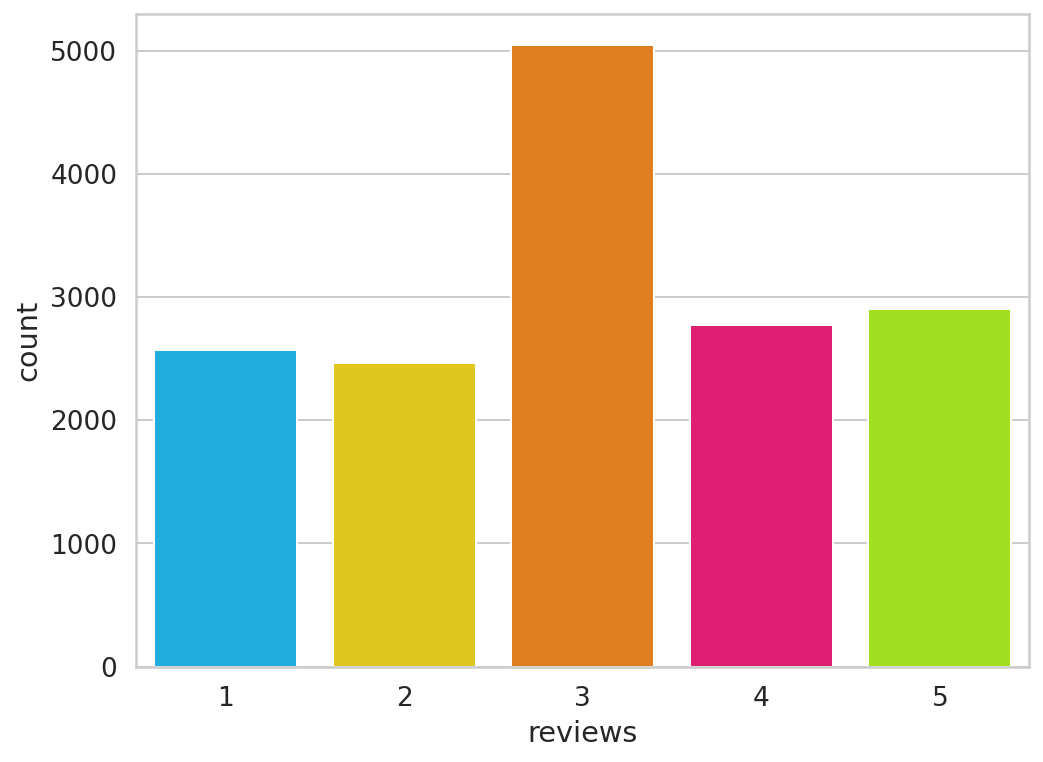

In [128]:
sns.countplot(df.score)
plt.xlabel("reviews")

In [129]:
def rating_to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    elif rating > 3:
        return 2

In [130]:
df["sentiment"] = df.score.apply(rating_to_sentiment)

In [131]:
df.tail()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner,2
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner,2
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner,2
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner,2
15745,Ahmed elsalamouni,https://lh3.googleusercontent.com/-9QSxVUhCoDI...,Really amazing and helped me sooo much just i ...,5,6,4.3.7,2018-02-04 22:57:09,NaN,NaN,newest,com.appxy.planner,2


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

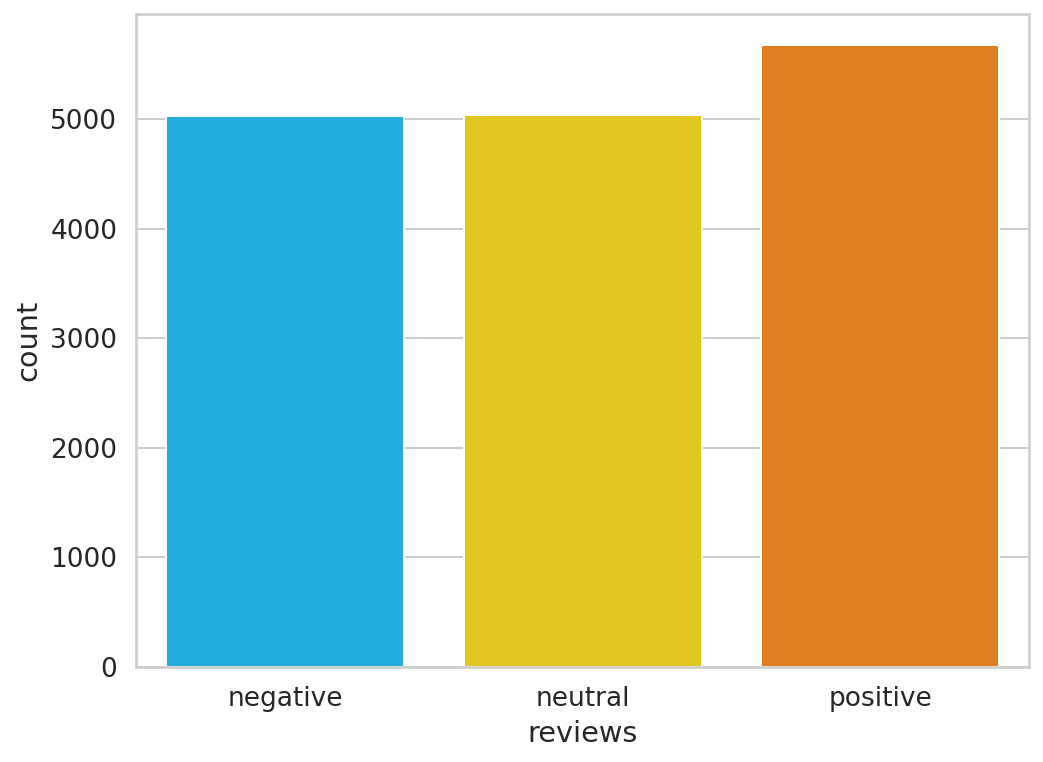

In [132]:
class_labels = ["negative", "neutral", "positive"]

ax = sns.countplot(df.sentiment)
plt.xlabel("reviews")
ax.set_xticklabels(class_labels)

Tranformers

In [133]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [134]:
sample_txt = "You're the beat in my chest tuned to cardiac arrest, I know, Am better off without you"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['you', "'", 're', 'the', 'beat', 'in', 'my', 'chest', 'tuned', 'to', 'cardiac', 'arrest', ',', 'i', 'know', ',', 'am', 'better', 'off', 'without', 'you']
[2017, 1005, 2128, 1996, 3786, 1999, 2026, 3108, 15757, 2000, 15050, 6545, 1010, 1045, 2113, 1010, 2572, 2488, 2125, 2302, 2017]


Special tokens

In [135]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [136]:
tokenizer.decode(tokenizer.encode(sample_txt))

"[CLS] you're the beat in my chest tuned to cardiac arrest, i know, am better off without you [SEP]"

In [137]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens=True,
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)

In [138]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2017,  1005,  2128,  1996,  3786,  1999,  2026,  3108, 15757,
         2000, 15050,  6545,  1010,  1045,  2113,  1010,  2572,  2488,  2125,
         2302,  2017,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [139]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [140]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))


['[CLS]', 'you', "'", 're', 'the', 'beat', 'in', 'my', 'chest', 'tuned', 'to', 'cardiac', 'arrest', ',', 'i', 'know', ',', 'am', 'better', 'off', 'without', 'you', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [141]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


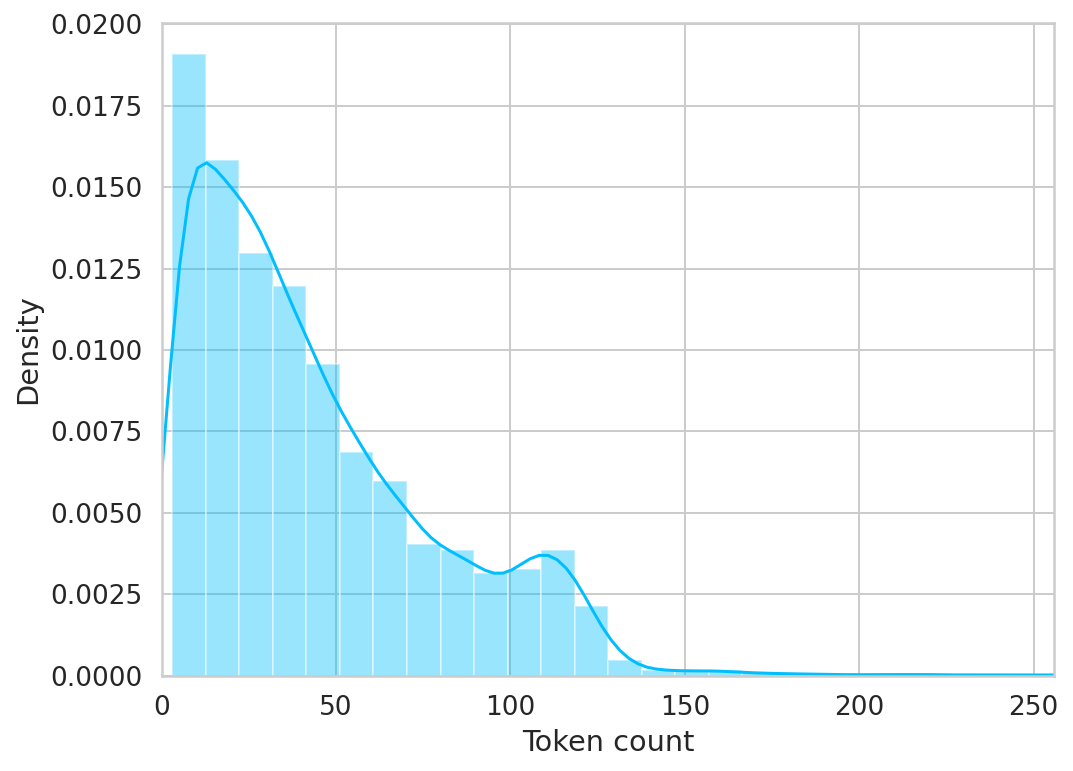

In [142]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [143]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS=100
BERT_NAME = "bert-base-uncased"

In [144]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [145]:
df_train, df_rem = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_rem, test_size=0.5, random_state=RANDOM_SEED)

In [146]:
df_train.shape, df_val.shape, df_test.shape


((14171, 12), (787, 12), (788, 12))

In [147]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [148]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [149]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [150]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [151]:
bert_model = BertModel.from_pretrained(BERT_NAME)

In [152]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
).values()

In [153]:
pooled_output.shape, last_hidden_state.shape

(torch.Size([1, 768]), torch.Size([1, 32, 768]))

In [154]:
bert_model.config.hidden_size

768

In [155]:
class SentimentClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_NAME)
        self.dropout = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, pooler_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).values()
        dropout_output = self.dropout(pooler_output)
        output = self.out(dropout_output)
        fin_output = self.softmax(output)
        return fin_output

In [156]:
model=SentimentClassifier(num_classes=len(class_labels))
model.load_state_dict(torch.load("best_model_state.bin"))
model = model.to(device)

In [157]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

In [158]:
model(input_ids, attention_mask)

tensor([[9.9996e-01, 2.6527e-05, 1.0404e-05],
        [6.4449e-05, 9.9992e-01, 1.6946e-05],
        [2.8328e-05, 9.9995e-01, 1.8451e-05],
        [1.2025e-05, 1.1997e-05, 9.9998e-01],
        [9.9997e-01, 1.5604e-05, 1.8267e-05],
        [7.0023e-06, 7.7845e-06, 9.9999e-01],
        [1.0102e-05, 9.9996e-01, 2.9922e-05],
        [1.2458e-05, 1.2455e-05, 9.9998e-01],
        [2.8485e-05, 2.4373e-05, 9.9995e-01],
        [3.0637e-05, 9.9992e-01, 4.9430e-05],
        [9.9992e-01, 3.5171e-05, 4.0016e-05],
        [1.2404e-05, 9.9995e-01, 3.7952e-05],
        [9.9995e-01, 2.0114e-05, 2.9748e-05],
        [9.9996e-01, 2.0561e-05, 1.4532e-05],
        [8.1492e-06, 9.9997e-01, 2.3742e-05],
        [9.9996e-01, 2.0951e-05, 2.1597e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

Different optimizer for the BERT and the hugging face parts
AdamW optimizer

In [159]:
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    correct_bias=False
)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Training function

In [160]:
from tqdm import tqdm

def train_fn(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_preds = 0
    for data in tqdm(dataloader, total=len(dataloader)):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["targets"].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_preds += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_preds.double() / n_examples , np.mean(losses)

In [161]:
def eval_model(model, dataloader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in tqdm(dataloader, total=len(dataloader)):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [162]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_fn(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


  0%|          | 0/886 [00:00<?, ?it/s]Epoch 1/100
----------

 26%|██▌       | 231/886 [01:44<05:02,  2.16it/s]